# Re-center Particles

How to update particle location centers from alignments in 2D Classification data. 

Before proceeding, [install the `cryosparc-tools` module](../intro.md) in your Python environment. Also ensure CryoSPARC base ports +2 and +3 (`40002` and `40003` in this example) are available on this machine.

The following python dependencies are also required to render results and may be installed with `conda` or `pip`:

* `pandas`
* `matplotlib`
* `numpy` (included with `cryosparc-tools`)

First initialize the `CryoSPARC` client:

In [1]:
from cryosparc.tools import CryoSPARC

cs = CryoSPARC(host="cryoem0.sbi", base_port=40000)
assert cs.test_connection()

Connection succeeded to CryoSPARC API at http://cryoem0.sbi:40002


This instance has a 2D Classification and Select 2D Classes job at `P251-J15` and `P251-J16`, respectively. Re-extract those selected particles with updated centers computed by the 2D Classification job.

First retrieve the job handle and its particles output with the `load_output` method.

In [2]:
project = cs.find_project("P377")
job = cs.find_job("P377", "J27")
particles = job.load_output("particles_selected")

Get a subset of relevant columns and display the first 10 rows as a `pandas` dataframe:

In [3]:
import pandas as pd

first_10 = particles.slice(0, 10)
first_10 = first_10.filter_fields(
    [
        "alignments2D/psize_A",
        "alignments2D/shift",
        "blob/psize_A",
        "location/center_x_frac",
        "location/center_y_frac",
        "location/micrograph_shape",
    ]
)
pd.DataFrame(first_10.rows())

alignments2D/psize_A alignments2D/shift  blob/psize_A  \
0                0.6575   [-1.125, -1.125]        0.6575   
1                0.6575   [-1.125, -1.125]        0.6575   
2                0.6575    [3.375, -3.375]        0.6575   
3                0.6575    [-3.375, 3.375]        0.6575   
4                0.6575   [-5.625, -3.375]        0.6575   
5                0.6575   [-3.375, -3.375]        0.6575   
6                0.6575    [-3.375, 1.125]        0.6575   
7                0.6575     [1.125, 1.125]        0.6575   
8                0.6575    [-3.375, 5.625]        0.6575   
9                0.6575  [-25.875, -1.125]        0.6575   

   location/center_x_frac  location/center_y_frac location/micrograph_shape  \
0                0.418966                0.165000              [7676, 7420]   
1                0.725862                0.430000              [7676, 7420]   
2                0.713793                0.588333              [7676, 7420]   
3                0.337931                0.070000              [7676, 7420]   
4                0.203448                0.308333              [7676, 7420]   
5                0.105172                0.878333              [7676, 7420]   
6                0.665517                0.946667              [7676, 7420]   
7                0.129310                0.218333              [7676, 7420]   
8                0.168966                0.546667              [7676, 7420]   
9                0.241379                0.968333              [7676, 7420]   

                    uid  
0   6555472342038759324  
1  12429352385936191949  
2   4413089813988380776  
3   7890869025919242735  
4   6624466740081947944  
5  15930749611494415454  
6  17867127395475584218  
7   1977580938600748347  
8  17308667439944230363  
9   8565532366270856702

Each particle has [`location/center_x_frac`, `location/center_y_frac`] fields which contain the fractional distance of each particle from the top-left corner of the micrograph. By convention, the top-left corner of the micrograph is `[0, 0]` and the bottom right corner is `[1, 1]`.

Use the shifts calculated by the 2D Classification job to modify the particle location. These are located at `alignments2D/shift` for each particle. The shift units are in pixels with pixel size `alignments2D/psize_A` (used during original computation of the 2D Class Averages).

Convert the original locations to pixels before doing the shift operation for increased floating point precision.

In [4]:
class2d_psize = particles["alignments2D/psize_A"]
micrograph_psize = particles["blob/psize_A"]

mic_shape_y, mic_shape_x = particles["location/micrograph_shape"].T
shift_x = class2d_psize * particles["alignments2D/shift"][:, 0] / micrograph_psize
shift_y = class2d_psize * particles["alignments2D/shift"][:, 1] / micrograph_psize
new_loc_x = particles["location/center_x_frac"] * mic_shape_x - shift_x
new_loc_y = particles["location/center_y_frac"] * mic_shape_y - shift_y

Create a copy of the particles dataset where the results are be saved. Convert the new locations back to fractions and reset the shift.

In [5]:
updated_particles = particles.copy()
updated_particles["location/center_x_frac"] = new_loc_x / mic_shape_x
updated_particles["location/center_y_frac"] = new_loc_y / mic_shape_y
updated_particles["alignments2D/shift"][:] = [0, 0]

Next, plot these particles onto a sample micrograph to check that the new locations were calculated correctly. First download the micrograph for one of the particles.

In [6]:
mic_path = particles["location/micrograph_path"][0]
header, mic = project.download_mrc(mic_path)

Use `matplotlib` to render the comparison plots. The following information is required for plotting:

* Downsampled and low-pass filtered micrograph with CryoSPARC's included utilities
* New downsampled width and height
* The min and maximum color range values, calculated as the 1st and 99th percentile pixel values to eliminate outliers
* The computed `(x, y)` pixel values at which to plot this micrograph's particles for the old and new locations


The old and new locations are rendered in yellow and cyan, respectively.

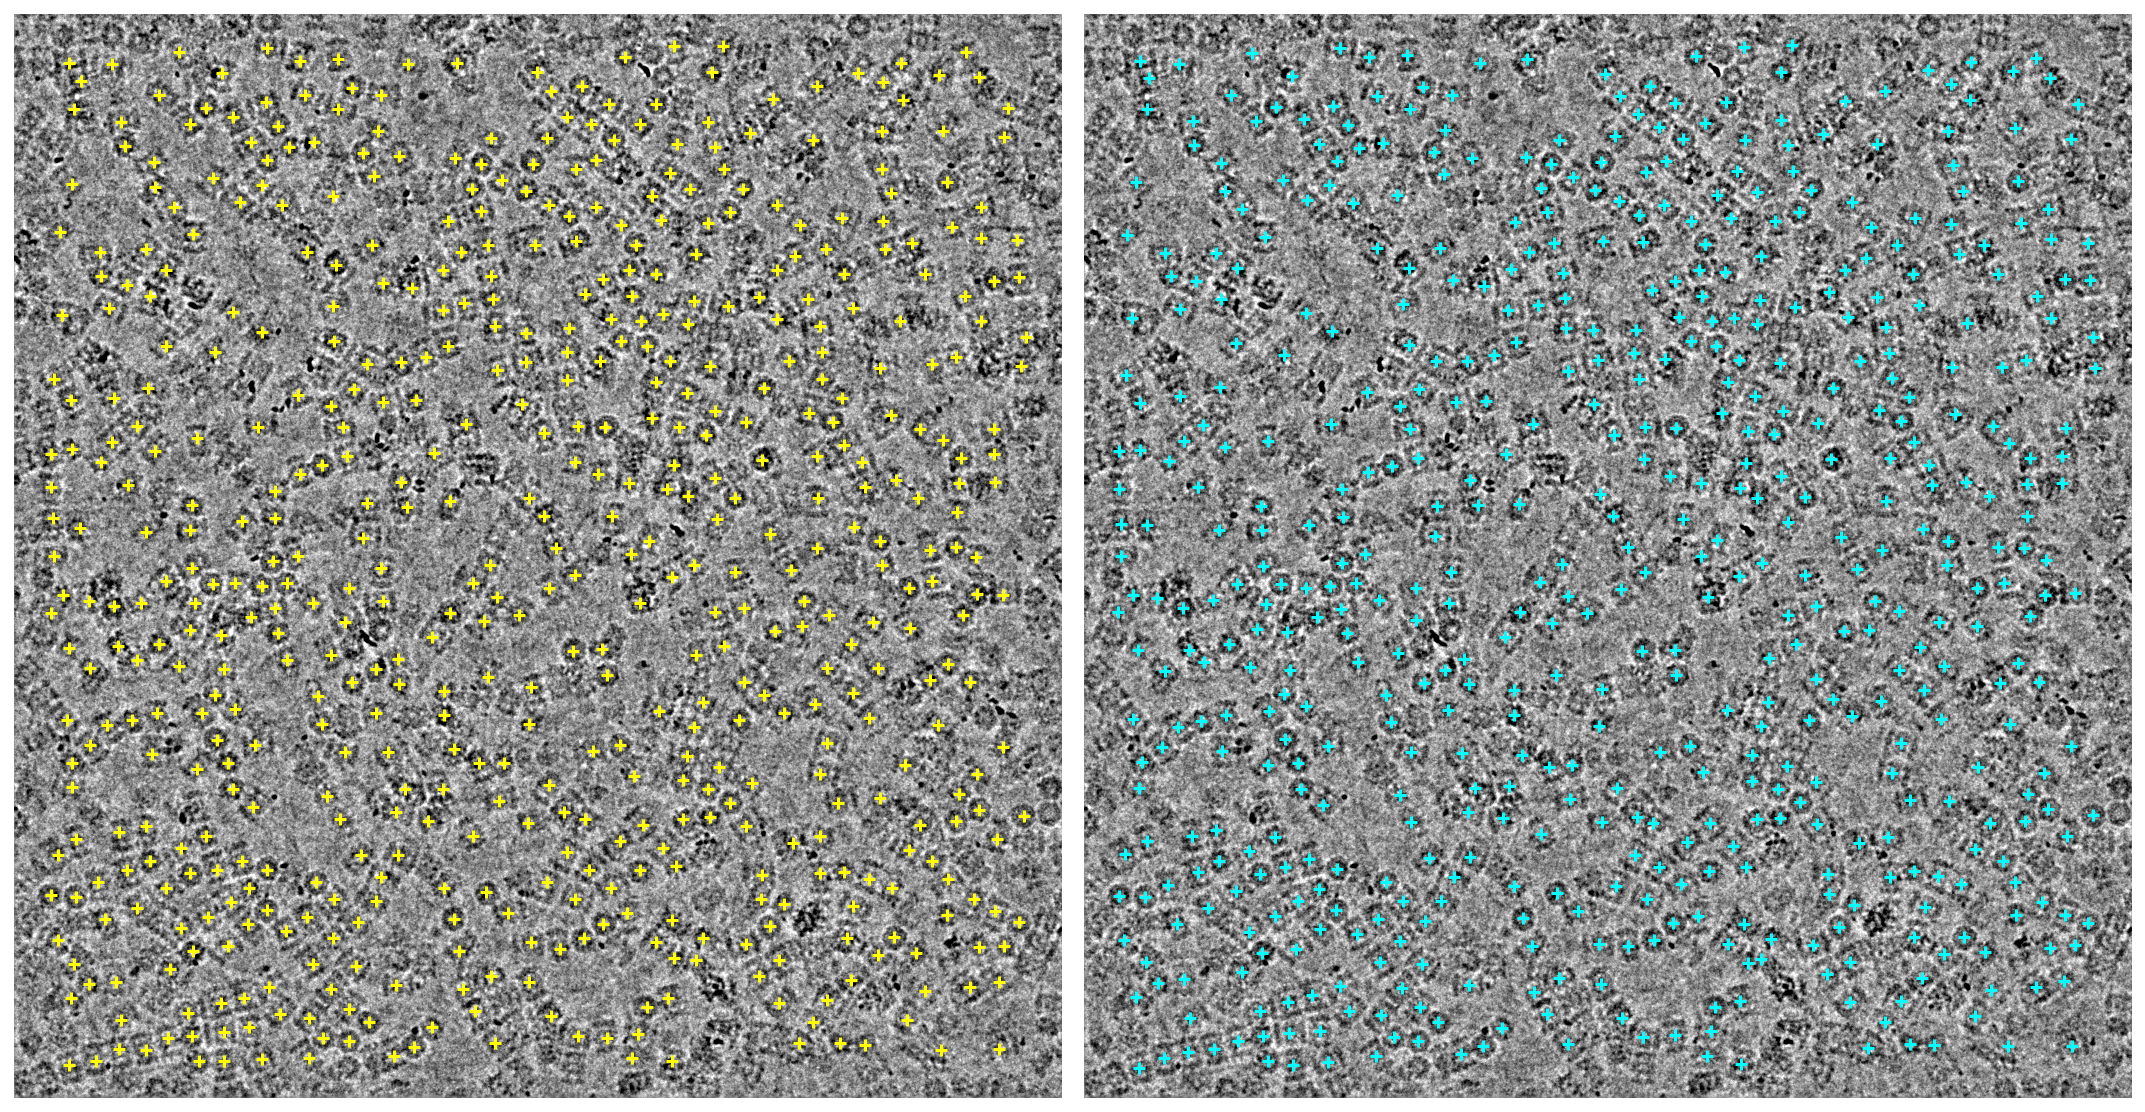

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from cryosparc.tools import downsample, lowpass2

# Initialize a 2x1 plot with axis labels dsiabled
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8), dpi=144)
ax1.axis("off")
ax2.axis("off")

# Downsample and lowpass micrograph
binned = downsample(mic, factor=3)
lowpassed = lowpass2(binned, psize_A=micrograph_psize[0], cutoff_resolution_A=20, order=0.7)
height, width = lowpassed.shape
vmin = np.percentile(lowpassed, 1)
vmax = np.percentile(lowpassed, 99)
ax1.imshow(lowpassed, cmap="gray", vmin=vmin, vmax=vmax, origin="lower")
ax2.imshow(lowpassed, cmap="gray", vmin=vmin, vmax=vmax, origin="lower")

# Plot old particles in yellow
mic_old_particles = particles.query({"location/micrograph_path": mic_path})
old_location_x = mic_old_particles["location/center_x_frac"] * width
old_location_y = mic_old_particles["location/center_y_frac"] * height
ax1.scatter(old_location_x, old_location_y, c="yellow", marker="+")

# Plot new particles in cyan
mic_new_particles = updated_particles.query({"location/micrograph_path": mic_path})
new_location_x = mic_new_particles["location/center_x_frac"] * width
new_location_y = mic_new_particles["location/center_y_frac"] * height
ax2.scatter(new_location_x, new_location_y, c="cyan", marker="+")

fig.tight_layout()

Those same locations overlaid on top of each other

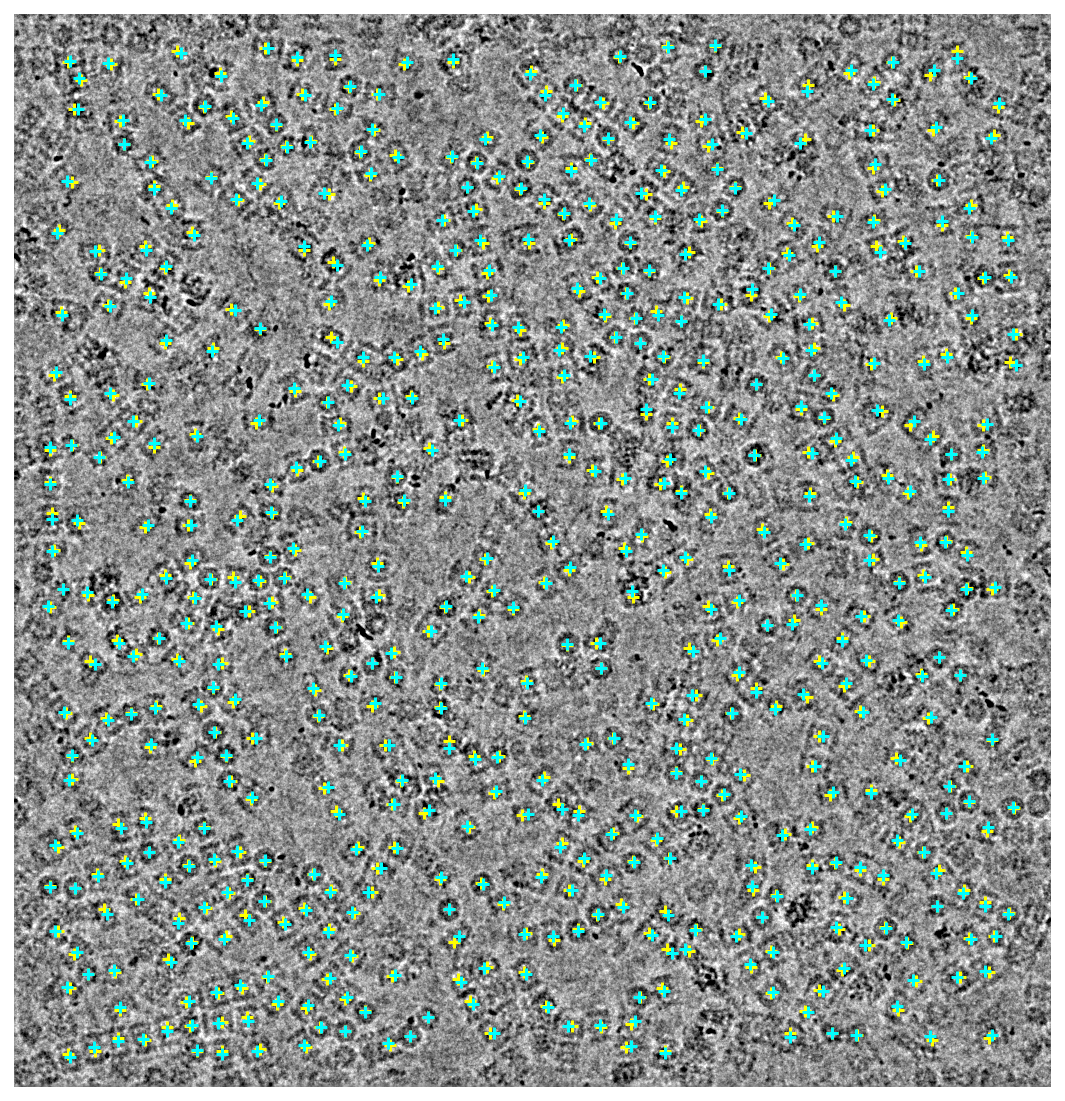

In [8]:
fig = plt.figure(figsize=(7.5, 8), dpi=144)
plt.axis("off")
plt.imshow(lowpassed, cmap="gray", vmin=vmin, vmax=vmax, origin="lower")
plt.scatter(old_location_x, old_location_y, c="yellow", marker="+")
plt.scatter(new_location_x, new_location_y, c="cyan", marker="+")

fig.tight_layout()

Use the `project.save_external_result()` method with the specified arguments to save the results back to CryoSPARC for extraction and further analysis. The result will be a new "External job" in CryoSPARC in the same workspace as the original job.

Use the `slots` argument to indicate that only the `location/` and `alignments2D/` fields have changed.

Specify the `passthrough` argument as a tuple of the original Select 2D job UID and the output where the particles were loaded from. This ensures that the result is correctly placed in the job tree.

In [9]:
project.save_external_result(
    workspace_uid="W2",
    dataset=updated_particles,
    type="particle",
    name="recentered_particles",
    slots=["location", "alignments2D"],
    passthrough=(job.uid, "particles_selected"),
    title="Recentered particles",
)

'J33'

Look for the "External" job with the number above in the CryoSPARC interface.